
# The algorithm




The data that was created which will be used for training was created by an algorthim that randomly choose the possible option for each hand. As a result, there is no strategy. It is our goal to create a strategy using a model based on the the players hand, dealers card, the running count, the true count and count for the round. The model will in the end tell the player to hit, double or stand. In addition, we will use the Thorp's Blackjack Basic Strategy chart by Edward O to determine when to split. 

We are using the high low system for counting the cards.
The card values are as follows:
2-6 = +1
7-9 = 0
10-Ace= -1
As each card is dealt, you will either add 1, subtract 1, or do nothing based on each card’s value. We will update our “running count” with the new information we are given. The count for the round is simply if we reset the count to zero after each round and return the running count at a give time. The true count is the running count divided by the remaining deck.

The algorithm automatically shuffles the deck once the used deck is between 60-75% completed. After each round, it will randomly choose a ratio between 60-75% and if the used deck is greater than the ratio, it will shuffle. 

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, log_loss,roc_auc_score,classification_report,confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import dump_svmlight_file
from sklearn.ensemble import GradientBoostingClassifier,VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RandomizedSearchCV
import pickle
from sklearn.model_selection import GridSearchCV

# Thorpes Strategy

In [4]:
thorpDF = pd.read_csv('thorp.csv')
thorpDF.set_index(['PlayerHand'], drop=True)
thorpDF

,PlayerHand,2,3,4,5,6,7,8,9,10,A
0,2,Hit,Hit,Hit,Hit,Hit,Hit,Hit,Hit,Hit,Hit
1,3,Hit,Hit,Hit,Hit,Hit,Hit,Hit,Hit,Hit,Hit
2,4,Hit,Hit,Hit,Hit,Hit,Hit,Hit,Hit,Hit,Hit
3,5,Hit,Hit,Hit,Hit,Hit,Hit,Hit,Hit,Hit,Hit
4,6,Hit,Hit,Hit,Hit,Hit,Hit,Hit,Hit,Hit,Hit
5,7,Hit,Hit,Hit,Hit,Hit,Hit,Hit,Hit,Hit,Hit
6,8,Hit,Hit,Hit,Hit,Hit,Hit,Hit,Hit,Hit,Hit
7,9,Hit,Double,Double,Double,Double,Hit,Hit,Hit,Hit,Hit
8,10,Double,Double,Double,Double,Double,Double,Double,Double,Hit,Hit
9,11,Double,Double,Double,Double,Double,Double,Double,Double,Double,Hit


In [5]:
df = pd.read_csv('export_dataframeTrainingRandom260419.csv')
df=df.drop(columns=["StartRunningCount","Player","BlackJackWin"])

#parameters of the model
number_of_players = 4
number_of_deck = 6 
df.head()

,ValueOfHand,Ace,DealerValue,theCountRound,runningCount,trueCount,Action,Result
0,13,0,10,-5,-5,-0.860927,Hit,0
1,17,0,10,-6,-6,-1.036545,Stand,0
2,20,0,10,-6,-6,-1.036545,Double,0
3,18,0,10,-7,-7,-1.213333,Stand,1
4,12,0,10,-4,-11,-1.972414,Stand,0


# Exploratory Data Analysis

Below is the results based on the action of the player. We can see that after hitting, there are no draws and a large proportion are loses. This pattern is the same for the other action except, there are a few draws and the proportion of loses to win is smaller

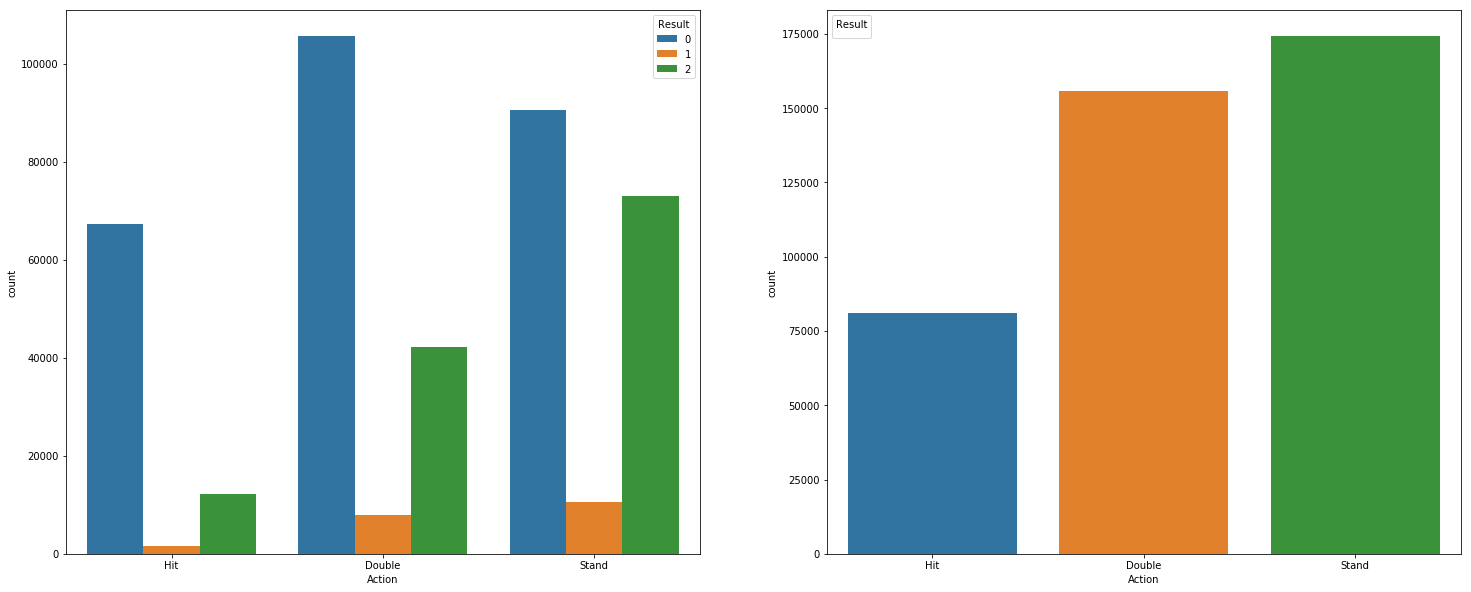

In [6]:
f, ax = plt.subplots(figsize=(25, 10),ncols = 2)
plot = sns.countplot(x="Action", hue="Result", data=df,ax=ax[0],order=["Hit","Double","Stand"])
plt.legend(title='Result', loc='upper left', labels=['Lose', 'Draw',"Win"])
plot = sns.countplot(x="Action", data=df,ax=ax[1],order=["Hit","Double","Stand"])


It should be noted that the data is for the last play of each player, thus all the action until the last play is not noted. For example, if a player initially is dealt with a 3,4 and hits a 5 and another 6 and then stands. The data will only collect the last play which is a players hand of (3+4+5 = 12). However, it would of taken into consideration the 5 from the card count. Thus, the hits are not recorded and for that reason, there are fewer hits than double and stand. In addition, we can see that there is a bigger difference in terms of win and lose because since it is the final play, the hand would be high and thus, by hitting, the player will bust. 



We should explore the thorpe strategy.

Text(0.5, 1.0, 'Player Value below 12')

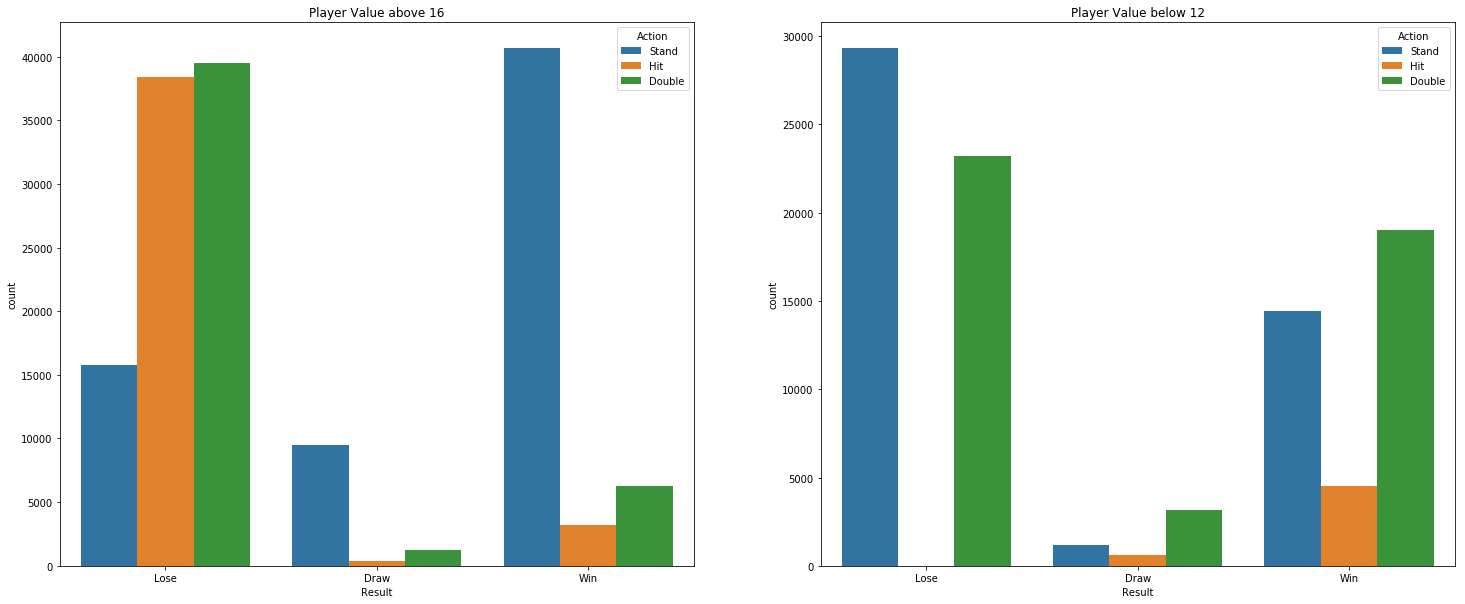

In [7]:
StandAbove17 = df.loc[(df["ValueOfHand"]>=17)]
Below11 = df.loc[(df["ValueOfHand"]<=11)]
label = ["Lose","Draw","Win"]
f, ax = plt.subplots(figsize=(25, 10),ncols=2)
plotAbove17 = sns.countplot(x="Result", hue="Action", data=StandAbove17,ax=ax[0],hue_order=["Stand","Hit","Double"])
plotAbove17.set_xticklabels(label, rotation='horizontal', fontsize=10)
plotAbove17.set_title("Player Value above 16")
plotBelow11 = sns.countplot(x="Result", hue="Action", data=Below11,ax=ax[1],hue_order=["Stand","Hit","Double"])
plotBelow11.set_xticklabels(label, rotation='horizontal', fontsize=10)
plotBelow11.set_title("Player Value below 12")


As we can see, when the players value is 17 or above, the player is more likely to win if he/she stands. When the players value is below 12, the player is more likely to lose when they stand (due to the dealer having a higher hand) and the player are more likely to win if they hit or double (as suggested by Thropes strategy).It makes logical sense to hit if the players hand is below 12 because the highest card would be a 10 (if a Ace is drawn, it could be counted as 1 or 11). As a result, the highest value after the hit would be 21 and any value between 11 and 21 gives a higher chance of beating the dealer than having a hand of below 12.


Lets look at the count

The lower the count, the more likely higher cards will be dealt as the lower cards have already been dealt. Card Counters use the true count because it takes into consideration of the remaining deck. We can have a negative running count but still be dealt with many more low cards if there are still a large amount of decks left. 

Text(0.5, 1.0, 'PlayerValue of 15 - low True Count')

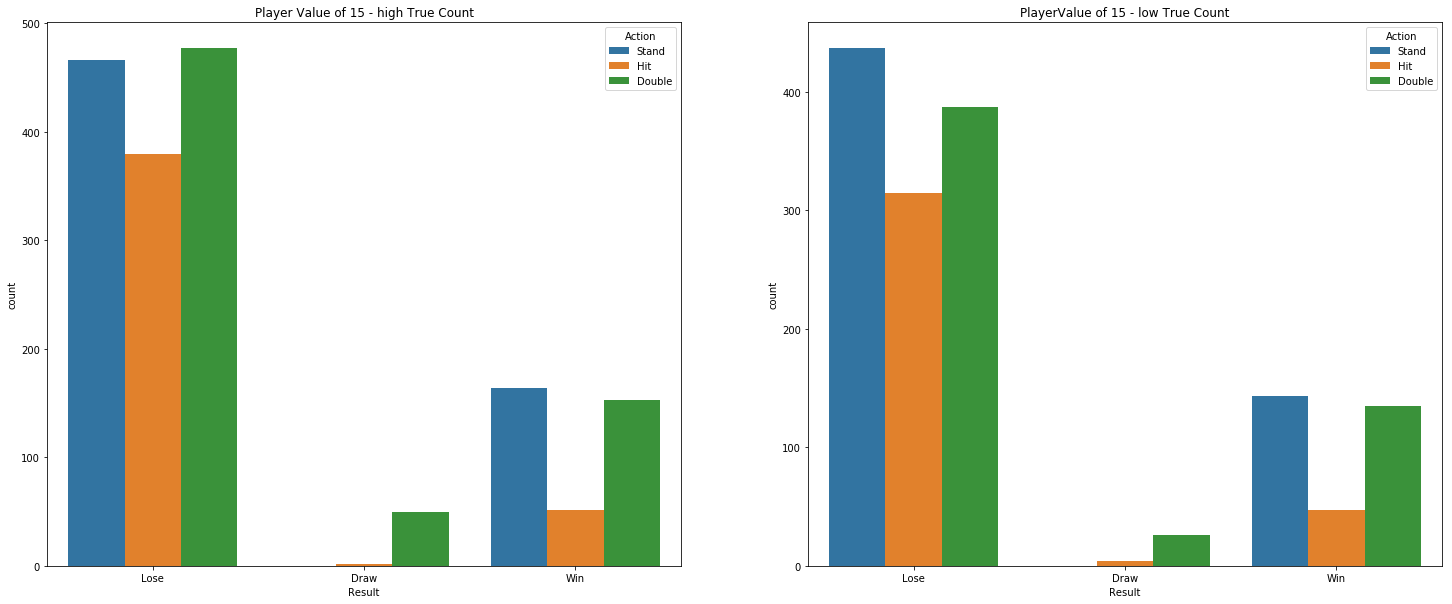

In [8]:
number_of_observation = df.shape[0]

topTrueCount = df.nlargest(int(number_of_observation*0.05), 'trueCount')
lowTrueCount = df.nsmallest(int(number_of_observation*0.05), 'trueCount')
StandAbove17 = topTrueCount.loc[(topTrueCount["ValueOfHand"]==15)]
StandAbove17low = lowTrueCount.loc[(lowTrueCount["ValueOfHand"]==15)]
label = ["Lose","Draw","Win"]
f, ax = plt.subplots(figsize=(25, 10),ncols=2)
plotAbove17 = sns.countplot(x="Result", hue="Action", data=StandAbove17,ax=ax[0],hue_order=["Stand","Hit","Double"])
plotAbove17.set_xticklabels(label, rotation='horizontal', fontsize=10)
plotAbove17.set_title("Player Value of 15 - high True Count")
plotBelow11 = sns.countplot(x="Result", hue="Action", data=StandAbove17low,ax=ax[1],hue_order=["Stand","Hit","Double"])
plotBelow11.set_xticklabels(label, rotation='horizontal', fontsize=10)
plotBelow11.set_title("PlayerValue of 15 - low True Count")

What we would like to see is that when there is a high true count, meaning its a higher chance of high cards being dealt, players with a value of 15 will more likely lose if they hit while if there is a low true count, the player with the same value is more likely to win if they hit since there is a higher chance of a low card being dealt and thus increasing their value without busting.  

However, after extracting the top and bottom 5 percent of the true counts and the player value of 15, we see that the two plots are very similar.

# Data Processing

In [9]:
df.dtypes

ValueOfHand        int64
Ace                int64
DealerValue        int64
theCountRound      int64
runningCount       int64
trueCount        float64
Action            object
Result             int64
dtype: object

We need to one hote encode the Action label in order to aviod the misinterpretation by the algorithms 

In [10]:
obj_df = df.select_dtypes(include=['object']).copy()
oneHotEncode = pd.get_dummies(obj_df, columns=["Action"])
oneHotEncode.head()

,Action_Double,Action_Hit,Action_Stand
0,0,1,0
1,0,0,1
2,1,0,0
3,0,0,1
4,0,0,1


In [11]:

data = pd.concat([df, oneHotEncode], axis=1)


We will discuss the importance of the labels "theCountRound" and "runningCount". Logically, the true count is more important than running count because it holds more information since it includes how my decks are left to deal. This applies to theCountRound which is the count for the round. As a result, we can drop both labels. However, in some cases (playing online and even at some casinos), we do not have information that is needed for the true count nor the running count and thus must solely rely on the count for the round. Thus, we will two analysis. One with the true count and another with only the count for the round. 

In [12]:
data_trueCount=data.drop(columns=["theCountRound","runningCount"])
data_RoundCount=data.drop(columns=["trueCount","runningCount"])

We will now normalise the data. Labels that are already ones and zeros do not need to be normalised.

In [13]:

nonScaledColumns = ["Ace","Action","Action_Double","Action_Hit","Action_Stand","Result"]


scaler = preprocessing.Normalizer()

scaled_data_trueCount = scaler.fit_transform(data_trueCount[["ValueOfHand","trueCount","DealerValue"]])
scaled_data_trueCount = pd.DataFrame(scaled_data_trueCount,columns =["ValueOfHand","trueCount","DealerValue"])
scaled_data_trueCount = pd.concat([scaled_data_trueCount,data_trueCount[nonScaledColumns]], axis=1)

scaled_data_RoundCount = scaler.fit_transform(data_RoundCount[["ValueOfHand","theCountRound","DealerValue"]])
scaled_data_RoundCount = pd.DataFrame(scaled_data_RoundCount,columns =["ValueOfHand","theCountRound","DealerValue"])
scaled_data_RoundCount = pd.concat([scaled_data_RoundCount,data_RoundCount[nonScaledColumns]], axis=1)

normalizerTrueCount = preprocessing.Normalizer().fit(data_trueCount[["ValueOfHand","trueCount","DealerValue"]]) 
normalizerRoundCount = preprocessing.Normalizer().fit(data_RoundCount[["ValueOfHand","theCountRound","DealerValue"]]) 

# Imbalance Class

In [14]:
freqClass = data_trueCount["Result"].value_counts().rename_axis('Class Results').reset_index(name='Count')
freqClass["Ratio"]=freqClass["Count"]/sum(freqClass["Count"].values)
freqClass

,Class Results,Count,Ratio
0,0,263578,0.641356
1,2,127304,0.309765
2,1,20088,0.048879


There is a imbalance class. The issue of using an imbalanced data would be that the output of the model would heavily influenced by the imbalance data and return mainly 0 since it is a majority. 

We can up-sample the minority class (duplicate the observation from minority classes), down- sample majority class( remove the observation from the majority class), change the performance metric to a Area Under ROC curve, use a cost sensitive training or use a Tree Based Algorithm. 



In [15]:
def UpSample(data):
    df_minority = data[data.Result==1]
    df_majority1 = data[data.Result==2]
    df_majority = data[data.Result==0]
    number_of_obsMinority = df_majority.shape[0]

    df_majority_upSample = resample(df_minority, replace=True, n_samples=number_of_obsMinority,random_state=123)
    df_majority1_upSample = resample(df_majority1, replace=True, n_samples=number_of_obsMinority,random_state=123)
    # Combine minority class with downsampled majority class
    df_upSample = pd.concat([df_majority_upSample, df_majority1_upSample,df_majority])

    return df_upSample
 





We will up sample the data in order to not lose any data. In addition, we will use a different performance metric. It should be noted that the up sample will be taken after the data split. 

# Spliting the data

In [16]:
Y_trainTrueCount = scaled_data_trueCount["Result"]
Y_trainRoundCount = scaled_data_RoundCount["Result"]

X_scaled_data_trueCount_unbalanced= scaled_data_trueCount.drop(columns=["Result","Action"])
X_scaled_data_roundCount_unbalanced = scaled_data_RoundCount.drop(columns=["Result","Action"])

# Unbalance
X_trainTrueCount_ub, X_testTrueCount_ub, y_trainTrueCount_ub, y_testTrueCount_ub = train_test_split(X_scaled_data_trueCount_unbalanced, Y_trainTrueCount, test_size=0.2, random_state=42)
X_trainRoundCount_ub, X_testRoundCount_ub, y_trainRoundCount_ub, y_testRoundCount_ub = train_test_split(X_scaled_data_roundCount_unbalanced, Y_trainRoundCount, test_size=0.2, random_state=42)

#Balance
xy_trainTrueCount = pd.concat([X_trainTrueCount_ub,y_trainTrueCount_ub],axis = 1)
xy_trainTrueCount = UpSample(data =xy_trainTrueCount)
X_trainTrueCount = xy_trainTrueCount.drop(columns=["Result"])
y_trainTrueCount = xy_trainTrueCount["Result"]

xy_trainRoundCount = pd.concat([X_trainRoundCount_ub,y_trainRoundCount_ub],axis = 1)
xy_trainRoundCount = UpSample(data =xy_trainRoundCount)
X_trainRoundCount = xy_trainRoundCount.drop(columns=["Result"])
y_trainRoundCount = xy_trainRoundCount["Result"]


We will use a confusion matrix and a classification report to measure the performance of each model. We will look at a Neural Network, Gradient Boosting and a Random Forest. We will apply both the TrueCount and RoundCount data and also balanced and non balanced data through the models. We will also create a ensemble model that use all three models and delivery an output based on a vote. 

Our main concern for the model would be the ability to predict correctly a win. Thus, the recall, precision and F1 for class 2 would be important. Precision is the ratio between the true positives and all the positives predicted by the model. In other words, of all the data that were labeled wins by the model, how many were actual wins. While recall is of all the actual wins, how many was labeled as a win. The F1 is a weighted average of the precision and recall. 

The way the model would work would be given data, the model would predict the result under all the possible actions (Hit, Stand or Double). As a result, it will return an 3x1 array of 0,1,2. In a perfect scenario, the model would simply choose the action which is mapped to a win(2) while the other actions would be mapped to either a lose a draw (0,1 respectively). We will discuss this in the prediction sector of the report. 

We will use the code from generate.py to generate the the game using the prediction from each model and data (True and Round count).

In [17]:

def optimal_class_weights(model,parameters,weight):
    weights = np.linspace(0.05, 0.95, 5) 
    classWeight = [{0: x, 1: 1.0-x} for x in weights]
    para = parameters
    para.update({weight: classWeight})
    for count,i in enumerate(classWeight):
        i.update({2:1-weights[count]})   
    gsc = GridSearchCV(
        estimator=model,
        param_grid=para,
        scoring='f1_weighted',
        cv=3,
        n_jobs = 3
    )
    grid_result = gsc.fit(X_trainTrueCount_ub, y_trainTrueCount_ub)
    print("Best parameters : %s" % grid_result.best_params_)

    # Plot the weights vs f1 score
    dataz = pd.DataFrame({ 'score': grid_result.cv_results_['mean_test_score'],
                           'weight': weights })
    dataz.plot(x='weight')
    return grid_result.best_params_

Since there will be imbalance data, we will have weight classes. This will be applied to the random forest and ensemble model. We will use grid search in order to find the optimal class weight. We have used the f1 score as a performance measurement for the gird search. 

In [20]:
def performance(prediction,y_test):
    print("Confusion Matrix")
    print(confusion_matrix(y_test, prediction))
    target_names = ['Lose', 'Draw', 'Win']
    print("Classification Report")
    print(classification_report(y_test ,prediction, target_names=target_names))
    return

We will use the confusion matrix and classification report as our measure

# Neural Network

Imbalanced and scaled data

In [21]:
MLPUnbalance = MLPClassifier(hidden_layer_sizes = (50,100,), max_iter=1000, alpha=1e-4,
                    solver='sgd', tol=1e-4, random_state=1,
                    learning_rate_init=.2,momentum=0.7,batch_size=1000)
mlpfitUB= MLPUnbalance.fit(X_trainTrueCount_ub, y_trainTrueCount_ub)
preds = MLPUnbalance.predict(X_testTrueCount_ub)
acc=performance(prediction=preds,y_test=y_testTrueCount_ub)


with open("Models_pickle/MLPUnbalance","wb") as f:
    pickle.dump(MLPUnbalance,f)

Confusion Matrix
[[48363     0  4279]
 [ 2572     0  1485]
 [16624     0  8871]]
Classification Report
              precision    recall  f1-score   support

        Lose       0.72      0.92      0.80     52642
        Draw       0.00      0.00      0.00      4057
         Win       0.61      0.35      0.44     25495

   micro avg       0.70      0.70      0.70     82194
   macro avg       0.44      0.42      0.42     82194
weighted avg       0.65      0.70      0.65     82194



C:\Users\AlankHoang\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\AlankHoang\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\AlankHoang\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Due to the imbalance data, the model doesn't even return an output of 1 (draw) for all the testing data. However, it has the highest score for the class 2 (win). The problem using this model with an imbalance class, would be the lack of output for a draw. It would be much better if we combined the wins and draw together and use a binary class. 

Balanced and scaled data

In [641]:
MLPbalance = MLPClassifier(hidden_layer_sizes = (50,100,), max_iter=1000, alpha=1e-4,
                    solver='sgd', tol=1e-4, random_state=1,
                    learning_rate_init=.2,momentum=0.7,batch_size=1000)
mlpfit = MLPbalance.fit(X_trainTrueCount, y_trainTrueCount)
preds = MLPbalance.predict(X_testTrueCount_ub)
acc=performance(prediction=preds,y_test=y_testTrueCount_ub)


with open("Models_pickle/MLPbalance","wb") as f:
    pickle.dump(MLPbalance,f)

confusion_matrix
[[34650 12585  5407]
 [  942  2298   817]
 [ 8560  9450  7485]]
classification_report
              precision    recall  f1-score   support

           0       0.78      0.66      0.72     52642
           1       0.09      0.57      0.16      4057
           2       0.55      0.29      0.38     25495

   micro avg       0.54      0.54      0.54     82194
   macro avg       0.48      0.51      0.42     82194
weighted avg       0.68      0.54      0.58     82194



The f1-score for the draws(1) is low due to the precision. The model labelled over 20000 draws but only 2298 were actual draws. Even though we balanced the data, the poor precision could be due to the fact there isn't enough variety compared to the other classes. As a result, the model can't learn as much when labelling a draw. We can see this problem throughout the other models. 

# Gradient Boosting

Imbalanced and Scaled

In [642]:
GradientBoostingUnBalance = GradientBoostingClassifier(n_estimators=20, learning_rate = 0.05, max_features=7, max_depth = 2, random_state = 0)
gbtrainUB = GradientBoostingUnBalance.fit(X_trainTrueCount_ub, y_trainTrueCount_ub)
preds = GradientBoostingUnBalance.predict(X_testTrueCount_ub)
acc=performance(prediction=preds,y_test=y_testTrueCount_ub)

with open("Models_pickle/GradientBoostingUnBalance","wb") as f:
    pickle.dump(GradientBoostingUnBalance,f)

confusion_matrix
[[52129     0   513]
 [ 3504     0   553]
 [21564     0  3931]]
classification_report
              precision    recall  f1-score   support

           0       0.68      0.99      0.80     52642
           1       0.00      0.00      0.00      4057
           2       0.79      0.15      0.26     25495

   micro avg       0.68      0.68      0.68     82194
   macro avg       0.49      0.38      0.35     82194
weighted avg       0.68      0.68      0.59     82194



C:\Users\AlankHoang\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\AlankHoang\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\AlankHoang\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Balanced and Scaled

In [643]:
GradientBoostingBalance = GradientBoostingClassifier(n_estimators=20, learning_rate = 0.05, max_features=7, max_depth = 2, random_state = 0)
gbtrain = GradientBoostingBalance.fit(X_trainTrueCount, y_trainTrueCount)
preds = GradientBoostingBalance.predict(X_testTrueCount_ub)
acc=performance(prediction=preds,y_test=y_testTrueCount_ub)

with open("Models_pickle/GradientBoostingBalance","wb") as f:
    pickle.dump(GradientBoostingBalance,f)

confusion_matrix
[[29958 15678  7006]
 [ 1115  1740  1202]
 [ 7757  8037  9701]]
classification_report
              precision    recall  f1-score   support

           0       0.77      0.57      0.66     52642
           1       0.07      0.43      0.12      4057
           2       0.54      0.38      0.45     25495

   micro avg       0.50      0.50      0.50     82194
   macro avg       0.46      0.46      0.41     82194
weighted avg       0.67      0.50      0.56     82194



# Random Forest Classifier

Unbalanced and scaled

Best parameters : {'class_weight': {0: 0.49999999999999994, 1: 0.5, 2: 0.5}, 'n_estimators': 100}
confusion_matrix
[[41652  1206  9784]
 [ 1892   384  1781]
 [12777  1219 11499]]
classification_report
              precision    recall  f1-score   support

           0       0.74      0.79      0.76     52642
           1       0.14      0.09      0.11      4057
           2       0.50      0.45      0.47     25495

   micro avg       0.65      0.65      0.65     82194
   macro avg       0.46      0.45      0.45     82194
weighted avg       0.64      0.65      0.64     82194



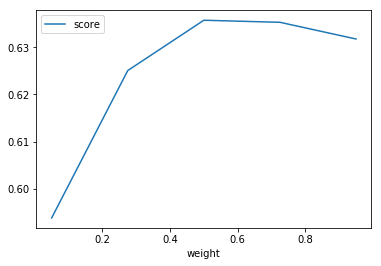

In [644]:
parameters = {"n_estimators":[100]}
optimal_param = optimal_class_weights(model=RandomForestClassifier(),parameters=parameters,weight="class_weight")

randomForestUnbalanced = RandomForestClassifier(**optimal_param)
randFUB = randomForestUnbalanced.fit(X_trainTrueCount_ub, y_trainTrueCount_ub)

preds = randomForestUnbalanced.predict(X_testTrueCount_ub)

acc=performance(prediction=preds,y_test=y_testTrueCount_ub)


with open("Models_pickle/randomForestUnbalanced","wb") as f:
    pickle.dump(randomForestUnbalanced,f)

As stated above, a method of combating the imbalance data is to use random forest. we can see that random forest labelled draws and has a relatively high f1 score for all classes. This is especially significant because the random forest is uisng imbalance data.

Balanced and scaled

In [645]:
randomForestbalanced = RandomForestClassifier(n_estimators=100)
randF = randomForestbalanced.fit(X_trainTrueCount, y_trainTrueCount)

preds = randomForestbalanced.predict(X_testTrueCount_ub)

acc=performance(prediction=preds,y_test=y_testTrueCount_ub)


with open("Models_pickle/randomForestbalanced","wb") as f:
    pickle.dump(randomForestbalanced,f)

confusion_matrix
[[37548  3694 11400]
 [ 1557   907  1593]
 [11194  3240 11061]]
classification_report
              precision    recall  f1-score   support

           0       0.75      0.71      0.73     52642
           1       0.12      0.22      0.15      4057
           2       0.46      0.43      0.45     25495

   micro avg       0.60      0.60      0.60     82194
   macro avg       0.44      0.46      0.44     82194
weighted avg       0.63      0.60      0.61     82194



Best parameters : {'weights': {0: 0.05, 1: 0.95, 2: 0.95}}
confusion_matrix
[[48036    27  4579]
 [ 2380    27  1650]
 [15799    65  9631]]
classification_report
              precision    recall  f1-score   support

           0       0.73      0.91      0.81     52642
           1       0.23      0.01      0.01      4057
           2       0.61      0.38      0.47     25495

   micro avg       0.70      0.70      0.70     82194
   macro avg       0.52      0.43      0.43     82194
weighted avg       0.66      0.70      0.66     82194



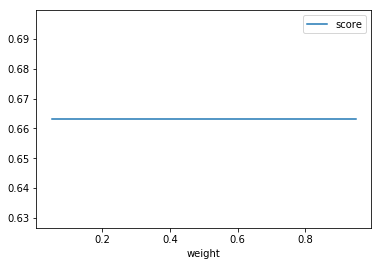

In [646]:
clf1 = GradientBoostingClassifier(n_estimators=20, learning_rate = 0.05, max_features=7, max_depth = 2, random_state = 0)
clf2 = RandomForestClassifier(n_estimators=100, random_state=1)
clf4 = MLPClassifier(hidden_layer_sizes = (50,100,), max_iter=1000, alpha=1e-4,
                    solver='sgd', tol=1e-4, random_state=1,
                    learning_rate_init=.2,momentum=0.7,batch_size=1000)

eclf2UB = VotingClassifier(estimators=[
     ('GB', clf1), ('rf', clf2), ('mlp', clf4)],voting='soft')
parameters = {}
optimal_param = optimal_class_weights(model=eclf2UB,parameters=parameters,weight="weights")
parameters = {"estimators":[('GB', clf1), ('rf', clf2), ('mlp', clf4)],"voting":'soft'}
parameters.update(optimal_param)
eclf2UB = VotingClassifier(**parameters)
vote = eclf2UB.fit(X_trainTrueCount_ub, y_trainTrueCount_ub)
preds = eclf2UB.predict(X_testTrueCount_ub)
    
acc=performance(prediction=preds,y_test=y_testTrueCount_ub)


with open("Models_pickle/voteUnBalance","wb") as f:
    pickle.dump(eclf2UB,f)

By combining the model but using imbalance data, the model was able to predict wins  better than other models but fell short on the draws. It had a high precision as it labelled 27 draws correctly out of 119 but a poor recall score as there were over 4000 actual draws. The class weights had no impact on the weighted average of the f1 scores. 

In [648]:
clf1 = GradientBoostingClassifier(n_estimators=20, learning_rate = 0.05, max_features=7, max_depth = 2, random_state = 0)
clf2 = RandomForestClassifier(n_estimators=100, random_state=1)

clf4 = MLPClassifier(hidden_layer_sizes = (50,100,), max_iter=1000, alpha=1e-4,
                    solver='sgd', tol=1e-4, random_state=1,
                    learning_rate_init=.2,momentum=0.7,batch_size=1000)

eclf2 = VotingClassifier(estimators=[
     ('GB', clf1), ('rf', clf2),('mlp', clf4)],voting='soft')
vote = eclf2.fit(X_trainTrueCount, y_trainTrueCount)
preds = eclf2.predict(X_testTrueCount_ub)

acc=performance(prediction=preds,y_test=y_testTrueCount_ub)


with open("Models_pickle/vote","wb") as f:
    pickle.dump(eclf2,f)

confusion_matrix
[[38595  3778 10269]
 [ 1459  1019  1579]
 [10778  3470 11247]]
classification_report
              precision    recall  f1-score   support

           0       0.76      0.73      0.75     52642
           1       0.12      0.25      0.17      4057
           2       0.49      0.44      0.46     25495

   micro avg       0.62      0.62      0.62     82194
   macro avg       0.46      0.48      0.46     82194
weighted avg       0.64      0.62      0.63     82194



The ensemble model with balance data has preformed overall better than other models since it has a higher f1 score in the win and draw class. 

We will create the models using the Round Count. Once again, the ensemble model with balance data has preformed overall better than other models.

C:\Users\AlankHoang\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\AlankHoang\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\AlankHoang\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


confusion_matrix
[[49135     0  3507]
 [ 2585     0  1472]
 [17188     0  8307]]
classification_report
              precision    recall  f1-score   support

           0       0.71      0.93      0.81     52642
           1       0.00      0.00      0.00      4057
           2       0.63      0.33      0.43     25495

   micro avg       0.70      0.70      0.70     82194
   macro avg       0.45      0.42      0.41     82194
weighted avg       0.65      0.70      0.65     82194

confusion_matrix
[[32426 11713  8503]
 [  776  2275  1006]
 [ 7226  8838  9431]]
classification_report
              precision    recall  f1-score   support

           0       0.80      0.62      0.70     52642
           1       0.10      0.56      0.17      4057
           2       0.50      0.37      0.42     25495

   micro avg       0.54      0.54      0.54     82194
   macro avg       0.47      0.52      0.43     82194
weighted avg       0.67      0.54      0.59     82194



C:\Users\AlankHoang\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\AlankHoang\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\AlankHoang\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


confusion_matrix
[[52112     0   530]
 [ 3502     0   555]
 [21546     0  3949]]
classification_report
              precision    recall  f1-score   support

           0       0.68      0.99      0.80     52642
           1       0.00      0.00      0.00      4057
           2       0.78      0.15      0.26     25495

   micro avg       0.68      0.68      0.68     82194
   macro avg       0.49      0.38      0.35     82194
weighted avg       0.68      0.68      0.59     82194

confusion_matrix
[[31455 13370  7817]
 [ 1209  1476  1372]
 [ 8512  6263 10720]]
classification_report
              precision    recall  f1-score   support

           0       0.76      0.60      0.67     52642
           1       0.07      0.36      0.12      4057
           2       0.54      0.42      0.47     25495

   micro avg       0.53      0.53      0.53     82194
   macro avg       0.46      0.46      0.42     82194
weighted avg       0.66      0.53      0.58     82194

Best parameters : {'class_weight

C:\Users\AlankHoang\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\AlankHoang\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\AlankHoang\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


confusion_matrix
[[49900     0  2742]
 [ 2420     0  1637]
 [16717     0  8778]]
classification_report
              precision    recall  f1-score   support

           0       0.72      0.95      0.82     52642
           1       0.00      0.00      0.00      4057
           2       0.67      0.34      0.45     25495

   micro avg       0.71      0.71      0.71     82194
   macro avg       0.46      0.43      0.42     82194
weighted avg       0.67      0.71      0.67     82194

confusion_matrix
[[34499  9728  8415]
 [  779  2220  1058]
 [ 7507  7258 10730]]
classification_report
              precision    recall  f1-score   support

           0       0.81      0.66      0.72     52642
           1       0.12      0.55      0.19      4057
           2       0.53      0.42      0.47     25495

   micro avg       0.58      0.58      0.58     82194
   macro avg       0.48      0.54      0.46     82194
weighted avg       0.69      0.58      0.62     82194



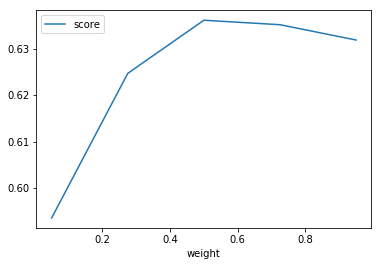

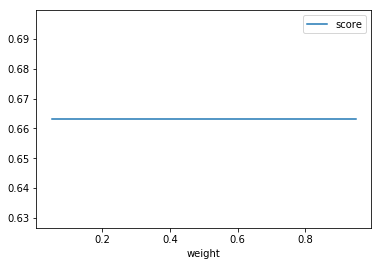

In [647]:
MLPUnbalance = MLPClassifier(hidden_layer_sizes = (50,100,), max_iter=1000, alpha=1e-4,
                    solver='sgd', tol=1e-4, random_state=1,
                    learning_rate_init=.2,momentum=0.7,batch_size=1000)
mlpfitUB= MLPUnbalance.fit(X_trainRoundCount_ub, y_trainRoundCount_ub)
preds = MLPUnbalance.predict(X_testRoundCount_ub)
acc=performance(prediction=preds,y_test=y_testRoundCount_ub)


with open("Models_pickle/MLPUnbalanceRound","wb") as f:
    pickle.dump(MLPUnbalance,f)
    
MLPbalance = MLPClassifier(hidden_layer_sizes = (50,100,), max_iter=1000, alpha=1e-4,
                    solver='sgd', tol=1e-4, random_state=1,
                    learning_rate_init=.2,momentum=0.7,batch_size=1000)
mlpfit = MLPbalance.fit(X_trainRoundCount, y_trainRoundCount)
preds = MLPbalance.predict(X_testRoundCount_ub)
acc=performance(prediction=preds,y_test=y_testRoundCount_ub)


with open("Models_pickle/MLPbalanceRound","wb") as f:
    pickle.dump(MLPbalance,f)
    
GradientBoostingUnBalance = GradientBoostingClassifier(n_estimators=20, learning_rate = 0.05, max_features=7, max_depth = 2, random_state = 0)
gbtrainUB = GradientBoostingUnBalance.fit(X_trainRoundCount_ub, y_trainRoundCount_ub)
preds = GradientBoostingUnBalance.predict(X_testRoundCount_ub)
acc=performance(prediction=preds,y_test=y_testRoundCount_ub)


with open("Models_pickle/GradientBoostingUnBalanceRound","wb") as f:
    pickle.dump(GradientBoostingUnBalance,f)
    
GradientBoostingBalance = GradientBoostingClassifier(n_estimators=20, learning_rate = 0.05, max_features=7, max_depth = 2, random_state = 0)
gbtrain = GradientBoostingBalance.fit(X_trainRoundCount, y_trainRoundCount)
preds = GradientBoostingBalance.predict(X_testRoundCount_ub)
acc=performance(prediction=preds,y_test=y_testRoundCount_ub)


with open("Models_pickle/GradientBoostingBalanceRound","wb") as f:
    pickle.dump(GradientBoostingBalance,f)

parameters = {"n_estimators":[100]}
optimal_param = optimal_class_weights(model=RandomForestClassifier(),parameters=parameters,weight="class_weight")
randomForestUnbalanced = RandomForestClassifier(**optimal_param)    
randFUB = randomForestUnbalanced.fit(X_trainRoundCount_ub, y_trainRoundCount_ub)

preds = randomForestUnbalanced.predict(X_testRoundCount_ub)

acc=performance(prediction=preds,y_test=y_testRoundCount_ub)



with open("Models_pickle/randomForestUnbalancedRound","wb") as f:
    pickle.dump(randomForestUnbalanced,f)
    
randomForestbalanced = RandomForestClassifier(n_estimators=100)
randF = randomForestbalanced.fit(X_trainRoundCount, y_trainRoundCount)

preds = randomForestbalanced.predict(X_testRoundCount_ub)

acc=performance(prediction=preds,y_test=y_testRoundCount_ub)



with open("Models_pickle/randomForestbalancedRound","wb") as f:
    pickle.dump(randomForestbalanced,f)
    
clf1 = GradientBoostingClassifier(n_estimators=20, learning_rate = 0.05, max_features=7, max_depth = 2, random_state = 0)
clf2 = RandomForestClassifier(n_estimators=100, random_state=1)
clf4 = MLPClassifier(hidden_layer_sizes = (50,100,), max_iter=1000, alpha=1e-4,
                    solver='sgd', tol=1e-4, random_state=1,
                    learning_rate_init=.2,momentum=0.7,batch_size=1000)

eclf2UB = VotingClassifier(estimators=[
     ('GB', clf1), ('rf', clf2), ('mlp', clf4)],voting='soft')
parameters = {}
optimal_param = optimal_class_weights(model=eclf2UB,parameters=parameters,weight="weights")
parameters = {"estimators":[('GB', clf1), ('rf', clf2), ('mlp', clf4)],"voting":'soft'}
parameters.update(optimal_param)
eclf2UB = VotingClassifier(**parameters)
vote = eclf2UB.fit(X_trainRoundCount_ub, y_trainRoundCount_ub)
preds = eclf2UB.predict(X_testRoundCount_ub)

acc=performance(prediction=preds,y_test=y_testRoundCount_ub)


with open("Models_pickle/voteUnBalanceRound","wb") as f:
    pickle.dump(eclf2UB,f)
    
clf1 = GradientBoostingClassifier(n_estimators=20, learning_rate = 0.05, max_features=7, max_depth = 2, random_state = 0)
clf2 = RandomForestClassifier(n_estimators=100, random_state=1)

clf4 = MLPClassifier(hidden_layer_sizes = (50,100,), max_iter=1000, alpha=1e-4,
                    solver='sgd', tol=1e-4, random_state=1,
                    learning_rate_init=.2,momentum=0.7,batch_size=1000)

eclf2 = VotingClassifier(estimators=[
     ('GB', clf1), ('rf', clf2),('mlp', clf4)],voting='soft')

vote = eclf2.fit(X_trainRoundCount, y_trainRoundCount)
preds = eclf2.predict(X_testRoundCount_ub)

acc=performance(prediction=preds,y_test=y_testRoundCount_ub)


with open("Models_pickle/voteRound","wb") as f:
    pickle.dump(eclf2,f)

# Prediction

In [22]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, log_loss,roc_auc_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
import pickle
from training import dataProcessAndTraining

model = dataProcessAndTraining(dataFile="export_dataframeTrainingRandom260419.csv",round_or_True="TrueCount")
data = model.dataProcess()
normalizerTrueCount = data["normalizer"]
model = dataProcessAndTraining(dataFile="export_dataframeTrainingRandom260419.csv",round_or_True="RoundCount")
data = model.dataProcess()
normalizerRoundCount = data["normalizer"]
thorpDF = pd.read_csv('thorp.csv')
thorpDF.set_index(['PlayerHand'], drop=True)

model_names=["MLPUnbalance","MLPbalance","GradientBoostingBalance","GradientBoostingUnBalance","randomForestUnbalanced","randomForestbalanced","vote","voteUnBalance",
"MLPUnbalanceRound","MLPbalanceRound","GradientBoostingBalanceRound","GradientBoostingUnBalanceRound","randomForestUnbalancedRound","randomForestbalancedRound",
"voteRound","voteUnBalanceRound"]

def model_selection(model_names):
    MODEL_SELECTION = {}
    for models in model_names:
        with open("Models_pickle/{}".format(models),"rb") as f:
            mod =pickle.load(f)
        MODEL_SELECTION [models] = mod
    return MODEL_SELECTION

MODEL_SELECTION = model_selection(model_names=model_names)

def processObs(observation,TrueCount):
    if TrueCount == True:
        obs = observation
        scaled_columns = ["ValueOfHand", "trueCount","DealerValue"]
        scen_action = pd.DataFrame(columns=["Action"])
        scen_action["Action"] = ["Hit","Stand","Double"]
        oneHotEncode = pd.get_dummies(scen_action, columns=["Action"])
        normalise = obs[["ValueOfHand", "trueCount","DealerValue"]].values.tolist()
        normalise
        scaled_instances =  normalizerTrueCount.transform(normalise)
        scaled_instances[0]
        obs=obs.drop(columns=["theCountRound","runningCount","Result","Action"])
        for count ,col in enumerate(scaled_columns):
            obs[col]=scaled_instances[0][count]
        obs=obs[["ValueOfHand", "trueCount","DealerValue","Ace"]]
        obs=obs.append([obs]*2,ignore_index=True,sort=False)
        obs = pd.concat([obs,oneHotEncode],axis=1)
        return obs
    elif TrueCount==False:
        obs = observation
        scaled_columns = ["ValueOfHand", "theCountRound","DealerValue"]
        scen_action = pd.DataFrame(columns=["Action"])
        scen_action["Action"] = ["Hit","Stand","Double"]
        oneHotEncode = pd.get_dummies(scen_action, columns=["Action"])
        normalise = obs[["ValueOfHand","theCountRound","DealerValue"]].values.tolist()
        scaled_instances =  normalizerRoundCount.transform(normalise)
        scaled_instances[0]
        obs=obs.drop(columns=["trueCount","runningCount","Result","Action"])
        for count ,col in enumerate(scaled_columns):
            obs[col]=scaled_instances[0][count]
        obs=obs[["ValueOfHand", "theCountRound","DealerValue","Ace"]]
        obs=obs.append([obs]*2,ignore_index=True,sort=False)
        obs = pd.concat([obs,oneHotEncode],axis=1)
        return obs

def recomThorp(obs,hand):
    #print(obs,hand)
    if obs["DealerValue"].iloc[0]==11:
        DealerValue = "A"
    else:
        DealerValue="{}".format(obs["DealerValue"].iloc[0])
    if isinstance(hand, list):
        for i in range (0,2,1):
            if hand[i] in ["J","Q","K"]:
                hand[i]=10
        playerHand = "{},{}".format(hand[0],hand[1])
        thorp = thorpDF.loc[thorpDF["PlayerHand"]==playerHand,[DealerValue]]
        thorp=thorp.values[0][0]
        return thorp
    elif hand==False:
        if obs["Ace"].iloc[0]==1:
            if obs["ValueOfHand"].iloc[0]>10:
                playerHand = "{}".format(int(obs["ValueOfHand"].iloc[0]))
            elif obs["ValueOfHand"].iloc[0]==1:
                playerHand = "A,A"
            else:
                playerHand = "A,{}".format(int(obs["ValueOfHand"].iloc[0])-1)
            thorp = thorpDF.loc[thorpDF["PlayerHand"]==playerHand,[DealerValue]]
            thorp=thorp.values[0][0]
        else:
            playerHand = "{}".format(obs["ValueOfHand"].iloc[0])
            thorp = thorpDF.loc[thorpDF["PlayerHand"]==playerHand,[DealerValue]]
            thorp=thorp.values[0][0]
        return thorp

def finalRecomendation(obs,hand,modelName,TrueCount):
    if isinstance(hand, list): 
        result = recomThorp(obs,hand)
    elif hand==False:
        recom = ["Hit","Stand","Double"]
        if obs["ValueOfHand"].iloc[0]>=17:
            result = "Stand"
            #print(result,"overide")
            return [0,1,0]
        elif obs["ValueOfHand"].iloc[0]<=11:
            result =recomThorp(obs,hand)
            #print(result,"overide")
            return [1,0,0]
        pObs= processObs(observation = obs,TrueCount=TrueCount)
        recommendation = MODEL_SELECTION[modelName].predict(pObs).tolist()
        if recommendation.count(2)==1:
            result = recom[recommendation.index(2)]
        elif (recommendation.count(1)==1)&(recommendation.count(2)==0):
            result = recom[recommendation.index(1)]
        elif recommendation == [1,0,1]:
            result = "Hit"
        else:
            result = recomThorp(obs,hand)  
        if (result=="Hit") &  (recomThorp(obs,hand)=="Double"):
            result = "Double"
        elif (result=="Double") &  (recomThorp(obs,hand)=="Hit"):
            result = "Hit"
        #print(result,"asdfsdfsd")
    return recommendation

Once we transform the raw data to encoded and scaled data, we can predict using the model. The observation will be copied 3 times for each action. 
    For example: obs = [13,0,7,0,20,8,"Hit",0]
    It will copied 3 times for each action:
    obs = [[13,0,7,0,20,8,"Hit",0],[13,0,7,0,20,8,"Stand",0],[13,0,7,0,20,8,"Double",0]]
    
After transforming the data, it will processed to the model and output an 3x1 array of 0,1,2. This represents the Result of the 3 observations. For example, [2,1,0] will mean that if the player hits, the model predicts a win, if the play stands, the model predicts a draw and if the player doubles, the model predicts a loss. Obvious actions such as hitting on a card values of less than or equal to 11 and standing on card values of more than or equal to 17 would overide the model. 

However, the model did not output unique responses such as the above but it would ouput responses such as [2,2,2] where there were more than 1 play. The plan to combat such problem was whenever the model output non unique responses, the model would use Thorpe Strategy. We did see a very similar win rate for all the models.

# Result

Model Comparsion - using Thorpe Stragety for non unique responses

After applying all the models to 10000 rounds of black jack with 4 players,The highest model was the Gradient Boosting using imbalanced and scaled round count data. The win rate is the ratio of all the wins by all the players and the number of plays in 10000 rounds. It should be noted, if both players have a blackjack, it is considered a draw since casino rules dictated that the player will be given their bets back. The model using random choice has a 30% win rate while using thrope strategy, the win rate has increased to 42%. The other models are within 42 and 44 percent.  This is intesesting because the round count provided less information than the true count. An explaination for this observation could be due to the fact that the counts have little weight in the model and as a result, all the models learnt the thorpe basic strategy. Once again, it could be due to the fact that the model has many non unique responses. In addition, even though the cards are random, the models that performed well could of had really good cards. 

We could also use another form of measuring the peformance of each model. If we incorporate money into the model and assume that a given player will put in 1 unit to play the round and put in extra if needed to split or double. If the player lost the round, the player would lose 1 unit. If the player drew, they would lose 0 units and if the player won, they would win 1 unit. If the player hit a blackjack while the dealer did not have a blackjack, the player would win 1.5 units. A blackjack is not a 21 meaning that a blackjack can only be won after the 2 cards have been dealt while a 21 is when the player hand equates to 21 and the player has more than 2 cards. A player with a 21 does not win 1.5 units but only 1 unit. In addition, if the player and dealer bust, it is a lost of 1 unit to the dealer and not a draw. 

In [23]:

def playerPayout(player,model):
    if player==False:
        theRun=model
    else:
        theRun= model.loc[(model["Player"]>=player)&(model["Player"]<player+1)]
    draw = theRun.loc[(theRun["Result"]==1)].shape[0]
    DoubleWins = theRun.loc[(theRun["Result"]==2)&(theRun["Action"]=="Double")].shape[0]
    DoubleLoses = theRun.loc[(theRun["Result"]==0)&(theRun["Action"]=="Double")].shape[0]
    WinOtherThanDoubles = theRun.loc[(theRun["Result"]==2)&(theRun["Action"]!="Double")&(theRun["BlackJackWin"]!=1)].shape[0]
    LosesOtherThanDouble = theRun.loc[(theRun["Result"]==0)&(theRun["Action"]!="Double")].shape[0]
    blackJack = theRun.loc[(theRun["BlackJackWin"]==1)&(theRun["Result"]==2)].shape[0]
    total = draw+DoubleWins+DoubleLoses+WinOtherThanDoubles+LosesOtherThanDouble+blackJack
    #print(total, theRun.shape[0])
    Payout = 0*draw+(2*(DoubleWins))+(-2*DoubleLoses)+(1*(WinOtherThanDoubles))+(-1*LosesOtherThanDouble)+(1.5*blackJack)
    return Payout

def thePayout(result_comparsion_file,folder_name,modelName,countingCards,theCount):
    result_comparsion = pd.read_csv("{}.csv".format(result_comparsion_file))
    modelRun = pd.read_csv("{}.csv".format(folder_name+"/"+modelName))
    modelRun = modelRun.iloc[0:20470]
    if countingCards!=False:
        if theCount==False:
            modelRun = modelRun.nlargest(int(20470*countingCards), 'StartRunningCount')
        else:
            modelRun= modelRun.loc[modelRun["StartRunningCount"]>theCount]  
            
    result = []
    result_comparsion.loc[result_comparsion["Model"]==model,["Number of plays"]]=modelRun.shape[0]
    for i in range(1,number_of_players+1):     
        result.append(playerPayout(player=i,model=modelRun))
    result.append(playerPayout(player=False,model=modelRun))
    return result





In [24]:
def finalTable(result_comparsion_file,folder_name,countingCards,theCount):
    if countingCards!=False:
        model_names = ["RandomRun","ThorpeRun","MLPUnbalance","MLPbalance","GradientBoostingBalance","GradientBoostingUnBalance",
               "randomForestUnbalanced","randomForestbalanced","vote","voteUnBalance"]
    else:    
        model_names = ["RandomRun","ThorpeRun","MLPUnbalance","MLPbalance","GradientBoostingBalance","GradientBoostingUnBalance",
               "randomForestUnbalanced","randomForestbalanced","vote","voteUnBalance",
              "MLPUnbalanceRound","MLPbalanceRound","GradientBoostingBalanceRound","GradientBoostingUnBalanceRound",
               "randomForestUnbalancedRound","randomForestbalancedRound","voteRound","voteUnBalanceRound"]
        
    column_name = ["Model"]
    for i in range(1,number_of_players+1):
        column_name.append('Player {}'.format(i))
    column_name.append("Total")

    payout = pd.DataFrame(columns = column_name)
    for model in model_names:
        result_comparsion = pd.read_csv("{}.csv".format(result_comparsion_file))
        result_comparsion = result_comparsion.sort_values('Win Rate', ascending=False)
        result_comparsion["Win Rate Rank"]=[i for i in range(1,result_comparsion.shape[0]+1)]
        row = {}
        result = thePayout(result_comparsion_file=result_comparsion_file,folder_name=folder_name,modelName=model,countingCards = countingCards, theCount = theCount)
        row["Model"]=model
        for index, columnValue in enumerate(column_name[1::]):
            row[columnValue]=result[index]
        payout=payout.append(row,ignore_index=True, sort=False)

    final = pd.merge(result_comparsion,payout,how='outer', on=["Model"])
    final = final.sort_values('Total', ascending=False)
    final["Total Payout Rank"]=[i for i in range(1,final.shape[0]+1)]
    return final.dropna()


The Gradient boosting performed the best by wining over 350 units. There were 7 models that beat the basic strategy in terms of the total payout and only 4 that were able to make a positive payout.  Once again it is interesting to note that it didn't matter whether the model used the round count or the true count because in the top 10 models, 5 of those models used the round count. The Ensemble Model using imbalanced and scaled True Count data performed poorly but still was proportionally smaller than a random model. 

In [29]:
finalTable(result_comparsion_file="model_comparsion_10000",folder_name="Model_Data_10000",countingCards = False, theCount = False).drop(columns=["Model"])

,Model Name,Info,Win Rate,Number of plays,Comment,Win Rate Rank,Player 1,Player 2,Player 3,Player 4,Total,Total Payout Rank
1,Gradient Boosting - Imbalance and Scaled Data,"4 Players, 6 Decks, 10000 Rounds",0.437395,41107,Round Count,2,57.0,157.0,117.0,21.0,352.0,1
6,Random Forest - Imbalance and Scaled Data,"4 Players, 6 Decks, 10000 Rounds",0.432260,41054,Round Count,7,2.0,158.5,58.5,76.0,295.0,2
0,Gradient Boosting - Imbalance and Scaled Data,"4 Players, 6 Decks, 10000 Rounds",0.438128,41109,True Count,1,27.5,51.5,17.5,80.0,176.5,3
2,Neural Network - Imbalance and Scaled Data,"4 Players, 6 Decks, 10000 Rounds",0.437053,41098,True Count,3,-35.5,13.0,60.0,83.5,121.0,4
4,Gradient Boosting - Balance and Scaled Data,"4 Players, 6 Decks, 10000 Rounds",0.434826,41113,Round Count,5,-20.0,20.5,45.5,-28.0,18.0,5
5,Gradient Boosting - Balance and Scaled Data,"4 Players, 6 Decks, 10000 Rounds",0.432845,41084,True Count,6,114.0,-126.5,-100.5,51.5,-61.5,6
3,Neural Network - Imbalance and Scaled Data,"4 Players, 6 Decks, 10000 Rounds",0.435358,41049,Round Count,4,-170.5,0.5,-9.0,75.0,-104.0,7
7,Thorpe Strategy - Basic Strategy,"4 Players, 6 Decks, 10000 Rounds",0.430867,41080,None,8,-81.5,-66.5,-103.0,52.5,-198.5,8
8,Ensemble Model - Imbalance and Scaled Data,"4 Players, 6 Decks, 10000 Rounds",0.429987,41071,Round Count,9,-122.5,-10.5,-44.5,-26.0,-203.5,9
14,Neural Network - Balance and Scaled Data,"4 Players, 6 Decks, 10000 Rounds",0.424914,41046,True Count,15,-55.0,-65.0,-38.0,-101.0,-259.0,10


As stated eariler, the models that preformed well could of simply been luckly and had 10000 rounds of good cards. In order to control that factor, we can give each model the exact cards that were played by a random model. generateSameDeck.py is used to create these models using fixed cards. 

In [28]:
finalTable(result_comparsion_file="model_comparsion_fixedCards10000",folder_name="Model_Data_fixedCards10000",countingCards = False, theCount = False).drop(columns=["Model"])

,Model Name,Info,Win Rate,Number of plays,Comment,Win Rate Rank,Player 1,Player 2,Player 3,Player 4,Total,Total Payout Rank
4,Gradient Boosting - Imbalance and Scaled Data,"4 Players, Same Cards as the Random Run",0.435330,41913,Round Count,5,69.0,-33.0,87.0,51.5,174.5,1
1,Gradient Boosting - Balance and Scaled Data,"4 Players, Same Cards as the Random Run",0.437158,42424,Round Count,2,3.0,85.5,22.0,31.5,142.0,2
5,Gradient Boosting - Imbalance and Scaled Data,"4 Players, Same Cards as the Random Run",0.434756,41950,True Count,6,51.0,-61.5,75.5,46.0,111.0,3
10,Random Forest - Balance and Scaled Data,"4 Players, Same Cards as the Random Run",0.432139,42049,Round Count,11,14.5,116.0,-68.5,42.5,104.5,4
0,Neural Network - Imbalance and Scaled Data,"4 Players, Same Cards as the Random Run",0.437220,42123,Round Count,1,16.0,33.0,62.5,-18.0,93.5,5
9,Neural Network - Balance and Scaled Data,"4 Players, Same Cards as the Random Run",0.432407,43126,Round Count,10,37.0,41.5,-36.0,31.0,73.5,6
3,Ensemble Model - Imbalance and Scaled Data,"4 Players, Same Cards as the Random Run",0.436581,41983,Round Count,4,-15.5,-54.5,91.0,36.0,57.0,7
2,Ensemble Model - Balance and Scaled Data,"4 Players, Same Cards as the Random Run",0.436728,42507,Round Count,3,-57.0,-27.5,63.5,29.0,8.0,8
11,Ensemble Model - Imbalance and Scaled Data,"4 Players, Same Cards as the Random Run",0.431386,42236,True Count,12,20.5,5.5,23.0,-75.0,-26.0,9
13,Neural Network - Imbalance and Scaled Data,"4 Players, Same Cards as the Random Run",0.429078,42335,True Count,14,63.0,-34.0,-27.5,-62.5,-61.0,10


Once again the Gradient Boosting using imbalanced and scaled round count data preformed the best. 12 models beat the basic strategy and 8 were able to produce a positive payout. 


In [37]:
dropColumns = ["Info","Win Rate","Win Rate Rank","Number of plays","Player 1","Player 2","Player 3","Player 4","Total"]

f10000 = finalTable(result_comparsion_file="model_comparsion_10000",folder_name="Model_Data_10000",countingCards = False, theCount = False).drop(columns=dropColumns)
fixed10000=finalTable(result_comparsion_file="model_comparsion_fixedCards10000",folder_name="Model_Data_fixedCards10000",countingCards = False, theCount = False).drop(columns=dropColumns)
final = pd.merge(f10000,fixed10000,on='Model')

final=final.drop(columns=["Model","Comment_x","Model Name_y"])
final["final rank"]=final.sum(axis=1)
final=final.sort_values('final rank', ascending=True)
final = final.rename(columns={'Model Name_x': 'Model Name', 'Total Payout Rank_x': '10000 Rounds Shuffled Cards Rank',"Comment_y":"Round or True Count", 'Total Payout Rank_y': '10000 Rounds Fixed Cards Rank','final rank': 'Final Points'})
final = final[["Model Name","Round or True Count","10000 Rounds Shuffled Cards Rank","10000 Rounds Fixed Cards Rank","Final Points"]]
final

,Model Name,Round or True Count,10000 Rounds Shuffled Cards Rank,10000 Rounds Fixed Cards Rank,Final Points
0,Gradient Boosting - Imbalance and Scaled Data,Round Count,1,1,2
2,Gradient Boosting - Imbalance and Scaled Data,True Count,3,3,6
4,Gradient Boosting - Balance and Scaled Data,Round Count,5,2,7
6,Neural Network - Imbalance and Scaled Data,Round Count,7,5,12
1,Random Forest - Imbalance and Scaled Data,Round Count,2,12,14
3,Neural Network - Imbalance and Scaled Data,True Count,4,10,14
10,Random Forest - Balance and Scaled Data,Round Count,11,4,15
8,Ensemble Model - Imbalance and Scaled Data,Round Count,9,7,16
9,Neural Network - Balance and Scaled Data,True Count,10,11,21
12,Ensemble Model - Balance and Scaled Data,Round Count,13,8,21


The final points column is simply the addition of the ranks of the model in the two scenarios. The lower the final points, the better the model. The Basic Strategy came in at equal 9th while the best model was the Gradient Boosting using imbalanced and scaled round count data. The round count dominated the top 10 models which once again in confusing as it provides less information on the deck than the true count. However, if this model was to be applied realisticly, using the round count would be easier since casinos have implemented methods to stop card counters. 

Warning
It should also be noted that depending on the casinos, they may implement other rules that will drastically drop both the payout and win rate. For example, some casinos do not allow splitting aces and if they do, you can only hit once after spliting the aces. In addition, the surrender option is not explored. Surrender allows the player to fold the card and lose 0.5 units if the dealer shown card is an ace or a card value of 10. This option may or may not improve the win or payout. 